### 1. Import libraries

### 2. Import data from Quandl

### 3. Subsetting, wrangling and cleaning data
  <ul>
<li>3.1 Subsetting</li>
    <li>3.2 Wrangling</li>
    <li>3.3 Check for missing values</li>
    <li>3.4 Check for duplicates</li>

### 4. Time-series analysis: decomposition

### 5. Time-series analysis: decomposition

### 6. Stationarizing the Historical Housing Market Data

# 1. Import libraries

In [32]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight')

# 2. Import data from Quandl

In [33]:
# Configure API key 

quandl.ApiConfig.api_key = 'PfozzU6Mo3pGGkSjGfGD'

In [34]:
# Importing the Yale Department of Economics, "Historical Housing Market Data" (US) variable.

df = quandl.get('YALE/RHPI')

In [35]:
df.head()

,Index
Date,
1890-12-31,100.000000
1891-12-31,88.011791
1892-12-31,95.421736
1893-12-31,92.297385
1894-12-31,123.980483


In [36]:
df.shape

(886, 1)

In [37]:
df.columns

Index(['Index'], dtype='object')

In [38]:
type(df)

pandas.core.frame.DataFrame

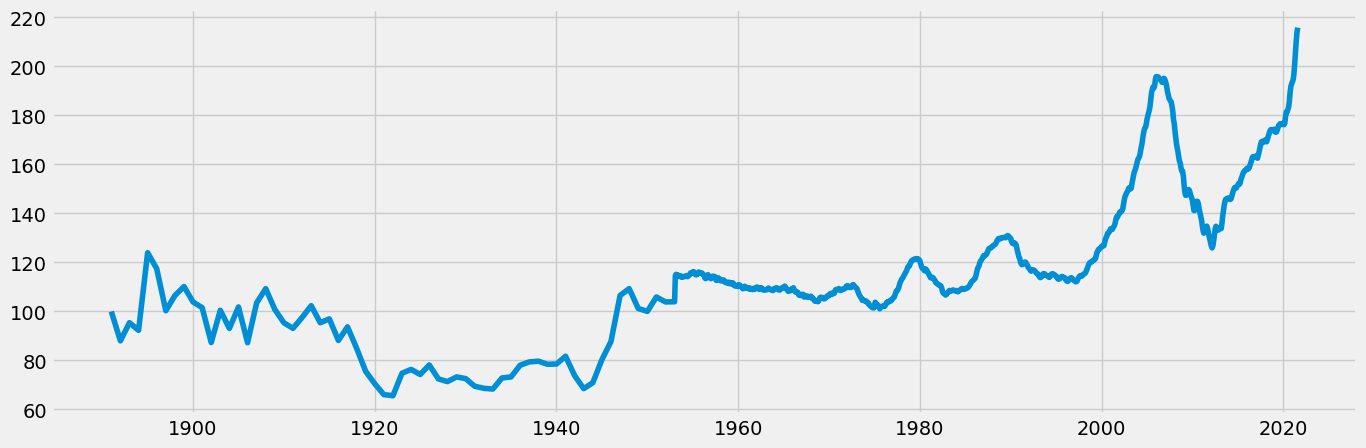

In [39]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df)

#### It's a clear upward curve regarding housing market in the US. 

# 3. Subsetting, wrangling and cleaning time-series data

### 3.1 Subsetting

In [40]:
# Reset index so I can use the "Date" column as a filter

df_2 = df.reset_index()

In [41]:
df_2.head()

,Date,Index
0,1890-12-31,100.000000
1,1891-12-31,88.011791
2,1892-12-31,95.421736
3,1893-12-31,92.297385
4,1894-12-31,123.980483


In [42]:
df_sub = df_2.loc[(df_2['Date'] >= '1970-01-01') & (df_2['Date'] < '2021-12-09')]

#### I chose to subset the data from 1970-01-01 to present. The most changes in the housing market is between now and ~50 years back.

In [43]:
df_sub.shape

(619, 2)

In [44]:
df_sub.head()

,Date,Index
267,1970-01-31,107.163459
268,1970-02-28,107.345544
269,1970-03-31,107.340173
270,1970-04-30,106.964014
271,1970-05-31,107.513224


### 3.2 Wrangling

In [45]:
# Set "Date" column as the index

from datetime import datetime

df_sub['datetime'] = pd.to_datetime(df_sub['Date']) # Create a datetime column from "Date."
df_sub = df_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
df_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
df_sub.head()

,Index
datetime,
1970-01-31,107.163459
1970-02-28,107.345544
1970-03-31,107.340173
1970-04-30,106.964014
1970-05-31,107.513224


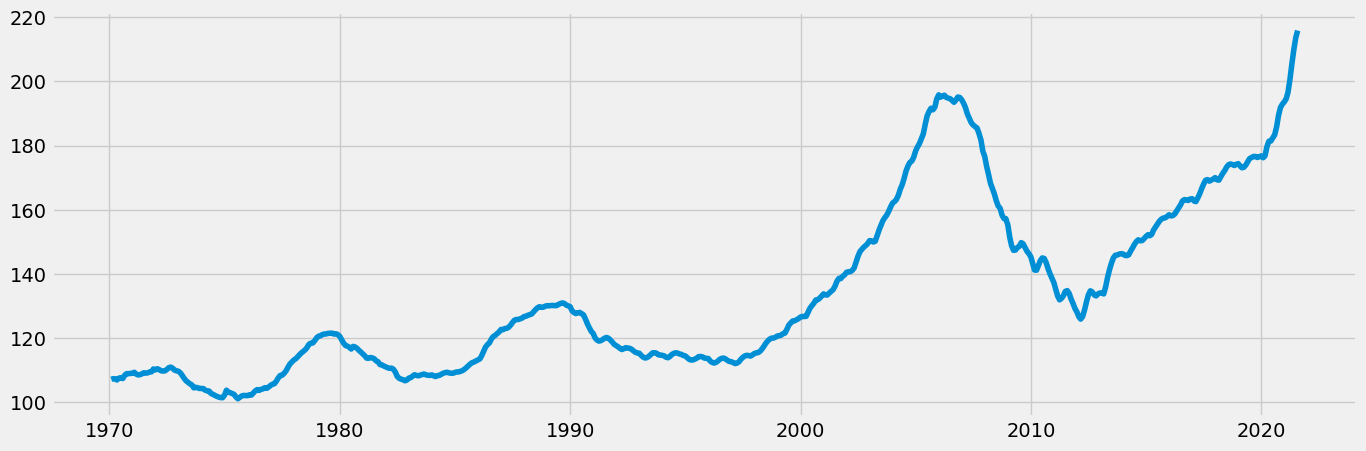

In [46]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_sub)

### 3.3 Check for missing values

In [47]:
# Check for missing values in the subset

df_sub.isnull().sum() 

Index    0
dtype: int64

#### No missing values

### 3.4 Check for duplicates

In [48]:
# Check for duplicates

dups = df_sub.duplicated()
dups.sum()

0

#### No duplicates

# 4. Time-series analysis: decomposition

In [49]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(df_sub, model='additive')

In [50]:
from pylab import rcParams 

rcParams['figure.figsize'] = 18, 7

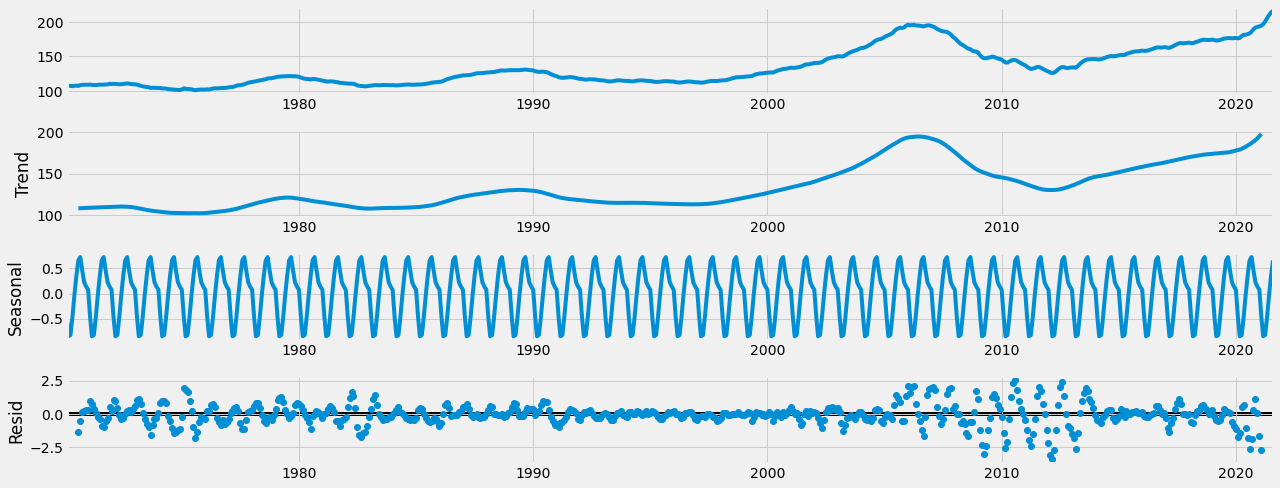

In [51]:
# Plot the separate components

decomposition.plot()
plt.show()

#### The line is relatively straight between 1970 and 2000, apart from two slight elevations around 1979 and around 1989. By the year 2000 it rises sharply and reaches its peak 2006-2007. The curve is on it's way up again (2020).

# 5. Testing for stationarity

In [52]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_sub['Index'])

Dickey-Fuller Stationarity test:
Test Statistic                   0.439631
p-value                          0.982918
Number of Lags Used             18.000000
Number of Observations Used    600.000000
Critical Value (1%)             -3.441296
Critical Value (5%)             -2.866369
Critical Value (10%)            -2.569342
dtype: float64


#### The Test Statistic is 0.3. The p-value is 0.9, and the test result is not significant as the p-value is grater than 0,05. The Critical Value (5%) is -2.8, and it's smaller than the Test Statistic. This means I cannot reject the null hypothesis. This indicates that there is a unit root in the data and that the data is likely non-stationary.

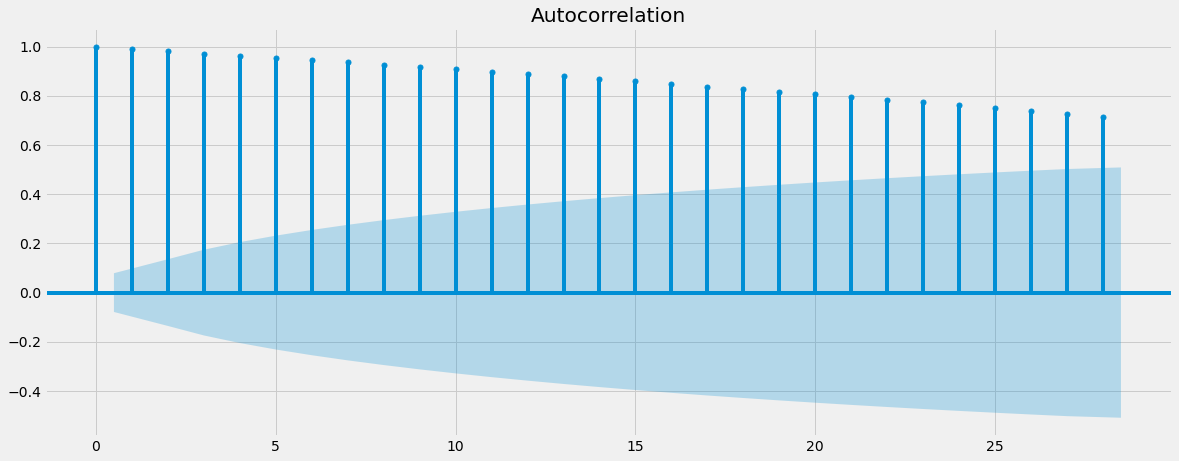

In [53]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_sub)
plt.show()

#### The autocorrelation shows that all the lags are above the blue edge of the confidence interval. The lags  are significantly correlated with each other, and it proof that the data is non-stationary.

# 6. Stationarizing the Historical Housing Market Data

In [54]:
df_diff = df_sub - df_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [55]:
df_diff.dropna(inplace = True) # Here, I remove the missing values that came about as a result of the differencing. 
# I need to remove these or I won't be able to run the Dickey-Fuller test.

In [56]:
df_diff.head()

,Index
datetime,
1970-02-28,0.182085
1970-03-31,-0.005371
1970-04-30,-0.376159
1970-05-31,0.549210
1970-06-30,0.176527


In [57]:
df_diff.columns

Index(['Index'], dtype='object')

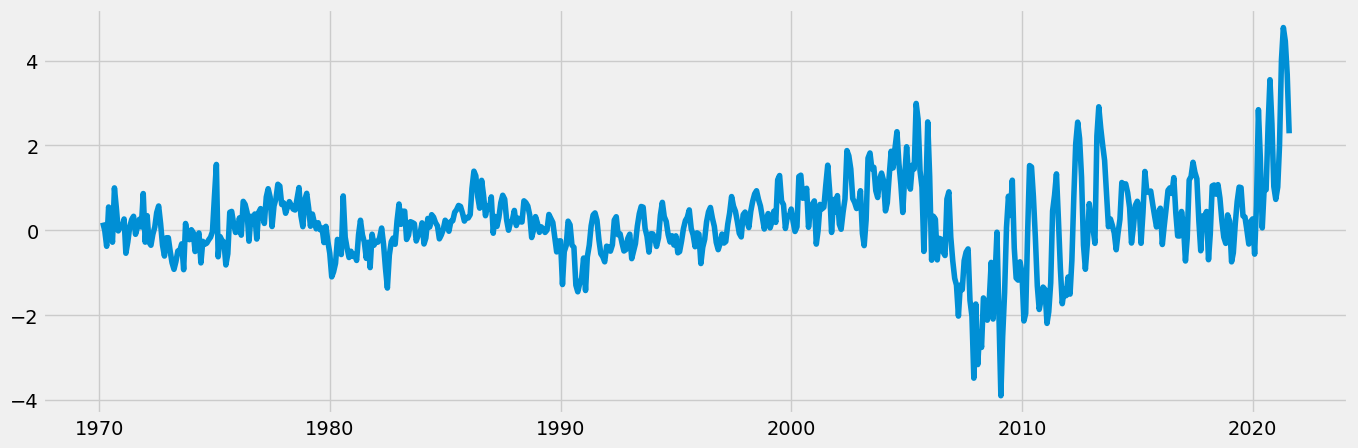

In [58]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_diff)

In [59]:
dickey_fuller(df_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -3.056960
p-value                          0.029907
Number of Lags Used             17.000000
Number of Observations Used    600.000000
Critical Value (1%)             -3.441296
Critical Value (5%)             -2.866369
Critical Value (10%)            -2.569342
dtype: float64


#### The Test Statistic (-3.0) is now smaller than the Critical Value 5% and 10% (-2.8, 2.5%). The p-value is 0.02. The Critical Value (5%) is -2.8, and it's larger than the Test Statistic. This means I can reject the null hypothesis. I also have a satisfactory p-value (p<0.05). This means I can reject the null hypothesis and, consider my series stationary.

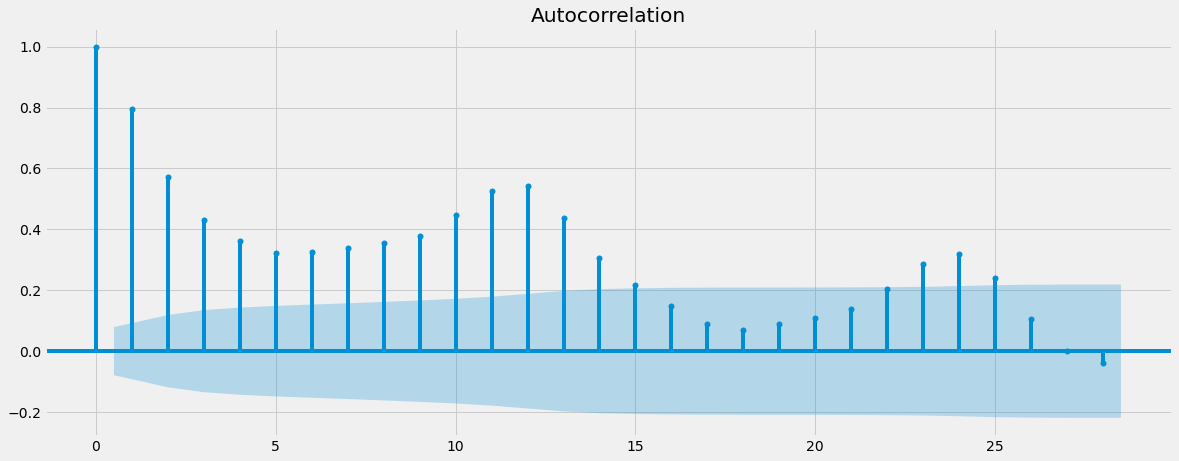

In [60]:
plot_acf(df_diff)
plt.show()